In [1]:
from SAXSsimulations import Simulation
from SAXSsimulations.plotting import *


In [30]:
simulation = Simulation(size = 10, nPoints = 501, volFrac = 0.05)
simulation.place_shape('sphere')

volume fraction is 0.00186, radius is 0.77, center at (0.3,1.3,2.7) 
volume fraction is 0.00396, radius is 0.79, center at (-0.6,1.3,0.8) 
volume fraction is 0.00606, radius is 0.80, center at (0.8,0.1,3.2) 
volume fraction is 0.00802, radius is 0.78, center at (-3.0,4.2,-1.9) 
volume fraction is 0.01045, radius is 0.84, center at (-3.7,-0.3,-1.5) 
volume fraction is 0.01220, radius is 0.75, center at (0.3,-0.5,-4.2) 
volume fraction is 0.01322, radius is 0.63, center at (2.6,4.4,3.6) 
volume fraction is 0.01429, radius is 0.64, center at (0.8,-3.3,-3.6) 
volume fraction is 0.01619, radius is 0.77, center at (1.5,3.4,-1.7) 
volume fraction is 0.01880, radius is 0.85, center at (-2.2,0.3,-3.4) 
volume fraction is 0.02018, radius is 0.69, center at (-2.3,-1.0,4.2) 
volume fraction is 0.02150, radius is 0.69, center at (-0.4,0.1,1.1) 
volume fraction is 0.02197, radius is 0.63, center at (-2.7,-1.1,4.0) 
volume fraction is 0.02340, radius is 0.70, center at (-3.4,2.3,0.3) 
volume fraction

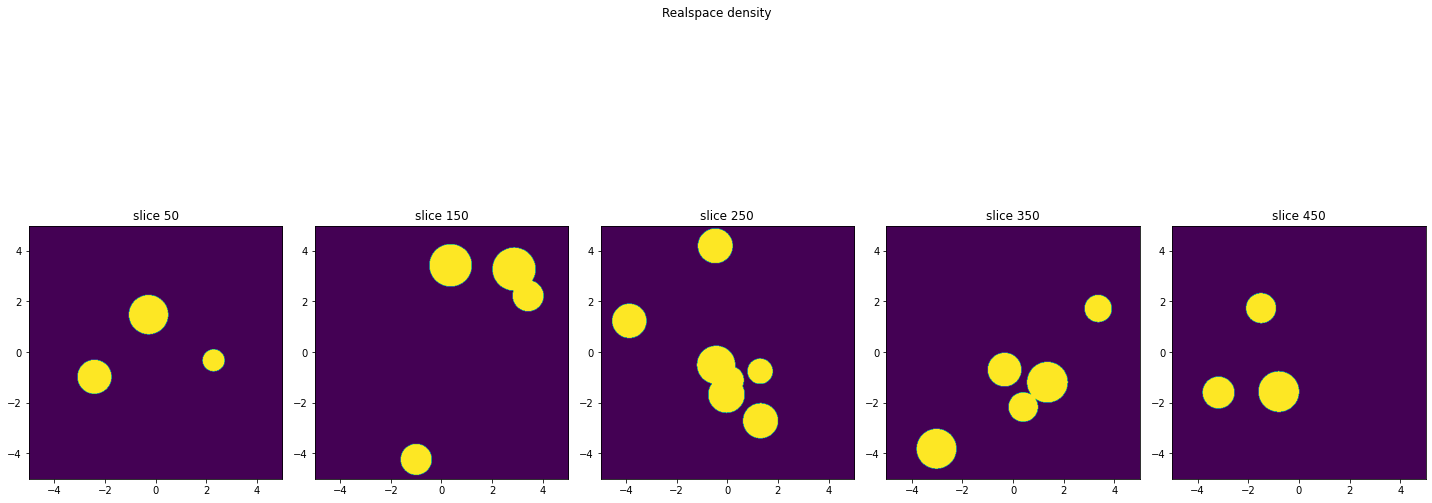

In [31]:
plot_slices(simulation.density, simulation.grid)

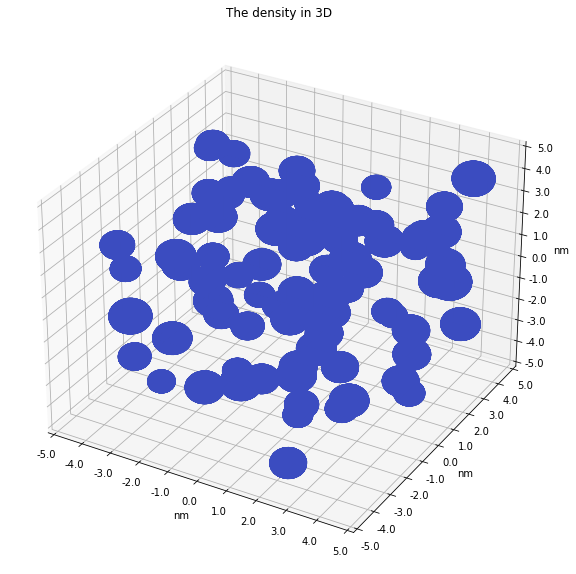

In [10]:
plot_3D_structure(simulation.density, simulation.grid, realspace=True)

In [34]:
simulation.calculate_custom_FTI_3D(device = 'cpu')
simulation.calculate_torch_FTI_3D(device = 'cpu')

the maximal difference between the implementation of the FTI is 0.0
173


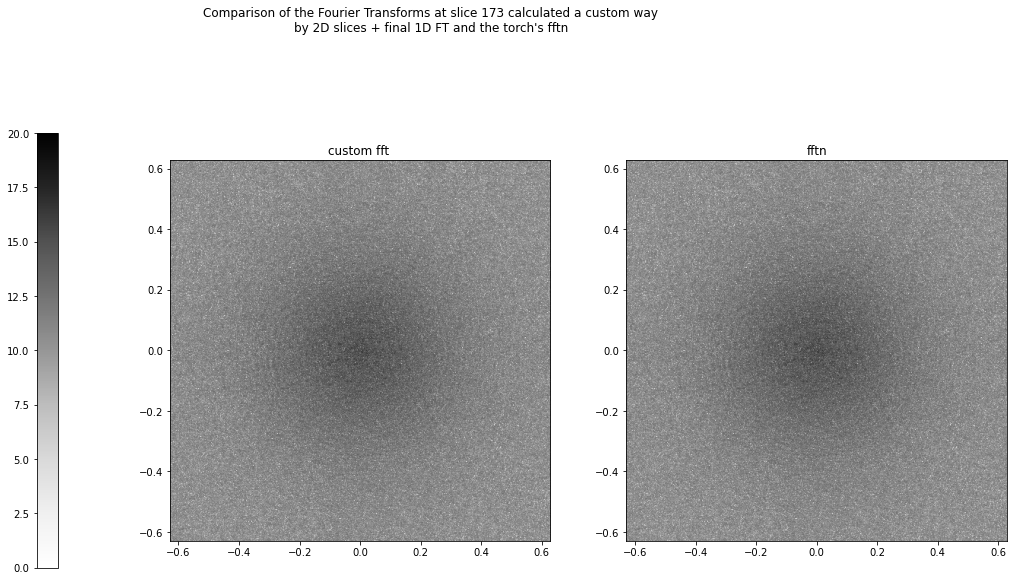

In [35]:
plot_FTI_version(simulation.FTI_custom, simulation.FTI_torch, simulation.qx)

In [13]:
import torch

KeyboardInterrupt: 

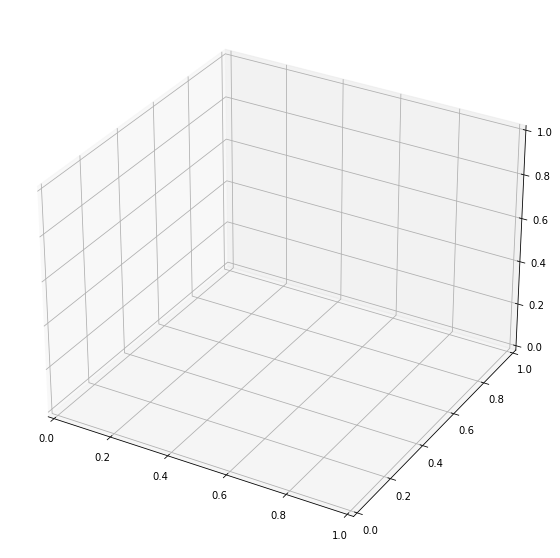

In [16]:
plot_3D_structure(torch.from_numpy(simulation.FTI), simulation.qx, realspace= False)

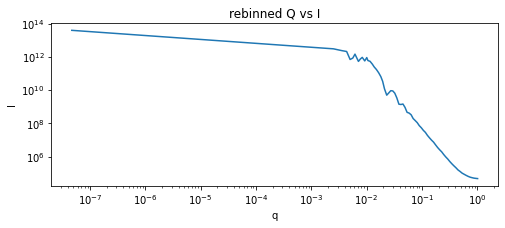

In [36]:
simulation.reBin(200)
plot_Q_vs_I(simulation.binned_data)

In [43]:
simulation.binned_data.assign(Q = simulation.binned_data.Q/10, I = simulation.binned_data.I/100, ISigma = simulation.binned_data.ISigma/100).to_csv('dat_files/polydispersed_spheres_{r}.dat'.
format(r = int(simulation.radius_global*100)), header=None, index=None, columns=["Q", "I", "ISigma"])
print("the sphere file with radius {r:.3f}  is saved".format(r = simulation.radius_global))

the cylinder file with radius 0.765  is saved


In [44]:
simulation = Simulation(size = 10, nPoints = 501, volFrac = 0.05)
simulation.place_shape('cylinder')

volume fraction is 0.00111, height is 6.57, radius is 0.97, center at (-0.3,-1.3,-2.6) 
volume fraction is 0.00244, height is 8.56, radius is 0.93, center at (2.5,-2.1,-3.5) 
volume fraction is 0.00316, height is 6.22, radius is 0.82, center at (1.0,3.3,-2.5) 
volume fraction is 0.00440, height is 7.14, radius is 0.99, center at (-2.7,-0.8,1.1) 
--->outside of x plane
volume fraction is 0.00539, height is 7.24, radius is 0.89, center at (-4.5,0.3,2.7) 
volume fraction is 0.00642, height is 7.38, radius is 0.90, center at (0.0,-1.1,2.5) 
--->outside of x plane
volume fraction is 0.00765, height is 6.12, radius is 1.07, center at (3.8,-3.8,0.6) 
volume fraction is 0.00847, height is 4.66, radius is 1.01, center at (-0.4,0.8,-2.0) 
--->outside of x plane
volume fraction is 0.00914, height is 3.80, radius is 1.03, center at (4.9,2.8,1.7) 
volume fraction is 0.00974, height is 5.33, radius is 0.95, center at (-0.5,-0.1,-1.8) 
volume fraction is 0.01127, height is 8.70, radius is 1.00, cente

In [46]:
simulation.calculate_custom_FTI_3D(device = 'cpu')
#simulation.calculate_torch_FTI_3D(device = 'cpu')
#simulation.plot_FTI_version(345)


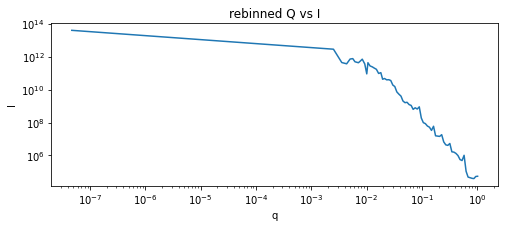

In [47]:
simulation.reBin(200)
plot_Q_vs_I(simulation.binned_data)

In [49]:
simulation.binned_data.assign(Q = simulation.binned_data.Q/10, I = simulation.binned_data.I/100, ISigma = simulation.binned_data.ISigma/100).to_csv('dat_files/polydispersed_cylinders_{r}_{h}.dat'.
format(r = int(simulation.radius_global*100), h = int(simulation.height_global*100)), header=None, index=None, columns=["Q", "I", "ISigma"])
print("the cylinder file with radius {r:.3f} and height {h:.3f} is saved".format(r = simulation.radius_global, h = simulation.height_global))

the cylinder file with radius 0.972 and height 6.565 is saved


In [28]:
simulation.binned_data

,I,IStd,ISEM,IError,Q,QStd,QSEM,QError,ISigma,QSigma
Q,,,,,,,,,,
"[4.68e-08, 5.09e-08)",3.973646e+13,3.973646e+13,3.973646e+13,3.973646e+13,4.677984e-08,4.677984e-08,4.677984e-08,4.677984e-08,3.973646e+13,4.677984e-08
"[0.00243, 0.00264)",5.979124e+11,1.721463e+11,9.938873e+10,2.401356e+11,2.513274e-03,2.700835e-08,1.559328e-08,1.184798e-03,2.401356e+11,1.184798e-03
"[0.0034, 0.00371)",9.747174e+10,1.054380e+10,6.087468e+09,1.309073e+10,3.554306e-03,1.909211e-08,1.102284e-08,2.052080e-05,1.309073e+10,3.554306e-05
"[0.00403, 0.00439)",1.651716e+11,2.317047e+04,1.638400e+04,3.131631e+10,4.353118e-03,2.206370e-08,1.560139e-08,3.078120e-05,3.131631e+10,4.353118e-05
"[0.00478, 0.0052)",4.514084e+11,1.916101e+11,1.106262e+11,2.664898e+11,5.026548e-03,2.700835e-08,1.559328e-08,2.369597e-03,2.664898e+11,2.369597e-03
...,...,...,...,...,...,...,...,...,...,...
"[0.712, 0.775)",2.275797e+05,8.628595e+04,3.854972e+03,3.400504e+02,7.418962e-01,1.547769e-03,6.914923e-05,3.314555e-04,3.854972e+03,7.418962e-03
"[0.775, 0.844)",2.008973e+05,4.292511e+04,1.917753e+03,3.439654e+02,8.059967e-01,1.730770e-03,7.732509e-05,3.600936e-04,2.008973e+03,8.059967e-03
"[0.844, 0.918)",1.959258e+05,9.178948e+04,4.100851e+03,6.065526e+02,8.702894e-01,6.413509e-03,2.865345e-04,3.888272e-04,4.100851e+03,8.702894e-03
